In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
import glob
import sys


from sklearn.model_selection import StratifiedKFold
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from sklearn.feature_selection import RFECV

from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from tabulate import tabulate

from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, LeaveOneOut, cross_val_score, GroupKFold, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error, explained_variance_score, accuracy_score

import pickle

warnings.filterwarnings("ignore")

# # Read the data from Empathy dataset

In [2]:
Files = glob.glob('E:/University of Essex/DataScience/Re-assesment/EyeT/*.csv')

readFile_count = len(Files)
print ("Eye-Tracking Data:", readFile_count);

Eye-Tracking Data: 502


In [4]:
def preprocess_data(data):
     # Drop the first column
    data = data.iloc[:, 1:]
    
    # List of columns to drop which not important for Empathy
    drop_column = ['Mouse position X', 'Mouse position Y', 'Fixation point X (MCSnorm)', 'Fixation point Y (MCSnorm)',
                    'Event', 'Event value',
                    'Computer timestamp', 'Export date', 'Recording date',
                    'Recording date UTC', 'Recording start time', 'Timeline name', 'Recording Fixation filter name',
                    'Recording software version', 'Recording resolution height', 'Recording resolution width',
                    'Recording monitor latency', 'Presented Media width', 'Presented Media height',
                    'Presented Media position X (DACSpx)', 'Presented Media position Y (DACSpx)', 'Original Media width',
                    'Recording start time UTC', 'Original Media height', 'Sensor']
    
   
    data[['Pupil diameter left', 'Pupil diameter right', 'Fixation point X', 'Fixation point Y']] = \
        data[['Pupil diameter left', 'Pupil diameter right', 'Fixation point X', 'Fixation point Y']].ffill()
    
    
    numeric_columns = ['Gaze direction left X', 'Gaze direction left Y', 'Gaze direction left Z',
                    'Gaze direction right X', 'Gaze direction right Y', 'Gaze direction right Z',
                    'Eye position left X (DACSmm)', 'Eye position left Y (DACSmm)', 'Eye position left Z (DACSmm)',
                    'Eye position right X (DACSmm)', 'Eye position right Y (DACSmm)', 'Eye position right Z (DACSmm)',
                    'Gaze point left X (DACSmm)', 'Gaze point left Y (DACSmm)', 'Gaze point right X (DACSmm)',
                    'Gaze point right Y (DACSmm)', 'Gaze point X (MCSnorm)', 'Gaze point Y (MCSnorm)',
                    'Gaze point left X (MCSnorm)', 'Gaze point left Y (MCSnorm)', 'Gaze point right X (MCSnorm)',
                    'Gaze point right Y (MCSnorm)', 'Pupil diameter left', 'Pupil diameter right']
    

    for col in numeric_columns:
        data[col] = pd.to_numeric(data[col].str.replace(',', '.'), errors='coerce')

    return data


In [6]:
def summarizing_eye_tracking_data(data, group):
    # Filter valid eye tracking data
    valid_data = data[(data['Validity left'] == 'Valid') & (data['Validity right'] == 'Valid')]

    # Count total fixations
    total_fixations = data[data['Eye movement type'] == 'Fixation'].shape[0]

    # Calculate average fixation duration
    avg_duration = data[data['Eye movement type'] == 'Fixation']['Gaze event duration'].mean()

    # Calculate statistics for different columns
    pupil_diameter = data[['Pupil diameter left', 'Pupil diameter right']].mean(axis=1).agg(['mean', 'median', 'std']).rename(lambda x: f'Pupil Diameter {x.capitalize()}')
    gaze_point_x = data['Gaze point X'].agg(['mean', 'median', 'std']).rename(lambda x: f'Gaze Point X {x.capitalize()}')
    gaze_point_y = data['Gaze point Y'].agg(['mean', 'median', 'std']).rename(lambda x: f'Gaze Point Y {x.capitalize()}')
    fixation_point_x = data['Fixation point X'].agg(['mean', 'median', 'std']).rename(lambda x: f'Fixation Point X {x.capitalize()}')
    fixation_point_y = data['Fixation point Y'].agg(['mean', 'median', 'std']).rename(lambda x: f'Fixation Point Y {x.capitalize()}')

    summary_data = {
        'Participant Name': data['Participant name'].iloc[0],
        'Project Name': group,
        'Recording Name': data['Recording name'].iloc[0],
        'Total Fixations': total_fixations,
        'Avg. Fixation Duration': avg_duration
    }
    summary_data.update(pupil_diameter)
    summary_data.update(gaze_point_x)
    summary_data.update(gaze_point_y)
    summary_data.update(fixation_point_x)
    summary_data.update(fixation_point_y)

    summary = pd.DataFrame(summary_data, index=[0])
    

    return summary

# # Pipeline

In [7]:
# Initialize an empty list to store processed Datasets
processed_data_list = []
current_iteration = 0


# Loop through each filename and process the data
for filename in Files:
    # Read the raw data from the CSV file
    raw_data = pd.read_csv(filename, usecols=lambda column: column != 0, low_memory=True)
     
    
    processed_data = preprocess_data(raw_data)
    
   
    file_name = os.path.basename(filename)
       
    # Determine the group based on the file name
    if file_name.startswith('EyeT_group_dataset_III_'):
        group = 'Test group experiment'
    elif file_name.startswith('EyeT_group_dataset_II_'):
        group = 'Control group experiment'
    
    
    summary = summarizing_eye_tracking_data(processed_data, group)
    processed_data_list.append(summary)
    
    current_iteration += 1
    
# Concatenate all the summaries into a single Datasets
print("Data summarization successful")
final_processed_df = pd.concat(processed_data_list, ignore_index=True)


Data summarization successful


In [8]:
final_processed_df.head()

,Participant Name,Project Name,Recording Name,Total Fixations,Avg. Fixation Duration,Pupil Diameter Mean,Pupil Diameter Median,Pupil Diameter Std,Gaze Point X Mean,Gaze Point X Median,Gaze Point X Std,Gaze Point Y Mean,Gaze Point Y Median,Gaze Point Y Std,Fixation Point X Mean,Fixation Point X Median,Fixation Point X Std,Fixation Point Y Mean,Fixation Point Y Median,Fixation Point Y Std
0,Participant0001,Test group experiment,Recording1,3959,271.230866,3.056368,3.055,0.146976,1070.355771,1024.0,273.425806,253.597742,263.0,293.880068,1068.048486,1025.0,267.415656,240.014733,283.0,273.403386
1,Participant0001,Test group experiment,Recording2,4235,224.831641,3.003070,3.015,0.129013,965.955342,965.0,306.457171,306.260339,324.0,273.827454,963.202383,963.0,313.929984,293.415570,316.0,286.250816
2,Participant0003,Test group experiment,Recording11,2070,157.457005,3.046213,3.050,0.199396,1017.325455,1000.0,304.629167,555.689808,608.0,301.311213,1025.024750,995.0,321.610589,511.385828,575.0,302.463961
3,Participant0003,Test group experiment,Recording12,3194,135.623043,2.930768,2.940,0.216362,984.012235,991.0,277.920121,588.452621,594.0,287.156051,966.134572,998.0,293.505633,583.479270,570.0,320.345364
4,Participant0003,Test group experiment,Recording13,2605,135.343954,2.854551,2.855,0.225505,1005.079682,994.0,303.708457,534.013693,541.0,291.773511,1014.128752,989.0,329.832332,500.207664,514.0,312.883568


# ## Exploratory Data Analysis (EDA)

In [9]:
pd.set_option('display.max_rows', None)

final_processed_df.head()

,Participant Name,Project Name,Recording Name,Total Fixations,Avg. Fixation Duration,Pupil Diameter Mean,Pupil Diameter Median,Pupil Diameter Std,Gaze Point X Mean,Gaze Point X Median,Gaze Point X Std,Gaze Point Y Mean,Gaze Point Y Median,Gaze Point Y Std,Fixation Point X Mean,Fixation Point X Median,Fixation Point X Std,Fixation Point Y Mean,Fixation Point Y Median,Fixation Point Y Std
0,Participant0001,Test group experiment,Recording1,3959,271.230866,3.056368,3.055,0.146976,1070.355771,1024.0,273.425806,253.597742,263.0,293.880068,1068.048486,1025.0,267.415656,240.014733,283.0,273.403386
1,Participant0001,Test group experiment,Recording2,4235,224.831641,3.003070,3.015,0.129013,965.955342,965.0,306.457171,306.260339,324.0,273.827454,963.202383,963.0,313.929984,293.415570,316.0,286.250816
2,Participant0003,Test group experiment,Recording11,2070,157.457005,3.046213,3.050,0.199396,1017.325455,1000.0,304.629167,555.689808,608.0,301.311213,1025.024750,995.0,321.610589,511.385828,575.0,302.463961
3,Participant0003,Test group experiment,Recording12,3194,135.623043,2.930768,2.940,0.216362,984.012235,991.0,277.920121,588.452621,594.0,287.156051,966.134572,998.0,293.505633,583.479270,570.0,320.345364
4,Participant0003,Test group experiment,Recording13,2605,135.343954,2.854551,2.855,0.225505,1005.079682,994.0,303.708457,534.013693,541.0,291.773511,1014.128752,989.0,329.832332,500.207664,514.0,312.883568


In [10]:
final_processed_df.isna().sum()

Participant Name           0
Project Name               0
Recording Name             0
Total Fixations            0
Avg. Fixation Duration     0
Pupil Diameter Mean        0
Pupil Diameter Median      0
Pupil Diameter Std         0
Gaze Point X Mean          0
Gaze Point X Median        0
Gaze Point X Std           0
Gaze Point Y Mean          0
Gaze Point Y Median        0
Gaze Point Y Std           0
Fixation Point X Mean      0
Fixation Point X Median    0
Fixation Point X Std       0
Fixation Point Y Mean      0
Fixation Point Y Median    0
Fixation Point Y Std       0
dtype: int64

### Get Count of CONTROL GROUP and TEST GROUP experiments

In [11]:
counts = final_processed_df['Project Name'].value_counts()

control_group_count = counts.get("Control group experiment", 0)
test_group_count = counts.get("Test group experiment", 0)

print(f' "Total Control Group Experiment": {control_group_count}')
print(f' "Total Test Group Experiment": {test_group_count}')

 "Total Control Group Experiment": 142
 "Total Test Group Experiment": 360


In [12]:
final_processed_df.describe()

,Total Fixations,Avg. Fixation Duration,Pupil Diameter Mean,Pupil Diameter Median,Pupil Diameter Std,Gaze Point X Mean,Gaze Point X Median,Gaze Point X Std,Gaze Point Y Mean,Gaze Point Y Median,Gaze Point Y Std,Fixation Point X Mean,Fixation Point X Median,Fixation Point X Std,Fixation Point Y Mean,Fixation Point Y Median,Fixation Point Y Std
count,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000
mean,5121.804781,320.871694,3.173988,3.158222,0.234660,923.285981,923.097610,279.284970,448.339797,453.477092,263.984316,924.914874,925.720120,268.667016,452.033705,456.316733,253.533741
std,3306.395421,148.527529,0.506284,0.504791,0.140840,79.442290,70.535395,57.166109,111.079774,129.147311,48.752133,83.141174,74.759113,67.888185,124.595834,141.850010,57.882347
min,86.000000,128.689189,1.663501,1.560000,0.091130,722.131808,521.000000,74.465079,126.130802,33.000000,75.999008,709.402528,519.000000,37.116274,92.052922,51.000000,50.883095
25%,2750.000000,226.378865,2.891573,2.880000,0.149947,864.999339,880.625000,246.333976,360.126144,351.000000,239.316822,871.058089,885.000000,234.694611,353.924966,346.250000,220.342216
50%,4235.000000,293.554707,3.061182,3.055000,0.199329,916.832980,919.000000,277.679647,458.373100,449.000000,265.869385,918.519809,917.000000,269.492978,460.838615,447.500000,258.349995
75%,6442.500000,377.788203,3.397512,3.330000,0.262802,968.486968,968.000000,311.732238,532.093230,548.750000,299.712629,964.012614,967.750000,313.929984,533.422764,558.000000,302.463961
max,16894.000000,1762.581701,5.676047,5.715000,1.179666,1263.553762,1255.000000,488.898311,807.105590,876.000000,431.907101,1302.523355,1345.000000,503.130855,882.295690,967.000000,365.617806


In [13]:
final_processed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 502 entries, 0 to 501
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Participant Name         502 non-null    object 
 1   Project Name             502 non-null    object 
 2   Recording Name           502 non-null    object 
 3   Total Fixations          502 non-null    int64  
 4   Avg. Fixation Duration   502 non-null    float64
 5   Pupil Diameter Mean      502 non-null    float64
 6   Pupil Diameter Median    502 non-null    float64
 7   Pupil Diameter Std       502 non-null    float64
 8   Gaze Point X Mean        502 non-null    float64
 9   Gaze Point X Median      502 non-null    float64
 10  Gaze Point X Std         502 non-null    float64
 11  Gaze Point Y Mean        502 non-null    float64
 12  Gaze Point Y Median      502 non-null    float64
 13  Gaze Point Y Std         502 non-null    float64
 14  Fixation Point X Mean    5

In [14]:
final_processed_df.shape

(502, 20)

## #Load Questionare dataset to read Empathy score

Here the goal is the empathy score.The total score extended will be used because it includes more questions that are more accurate in measuring empathy. 

In [15]:
df_questionare = pd.read_csv('E:/University of Essex/DataScience/Re-assesment/Empathy_Score/Questionnaire_datasetIA.csv', encoding='ISO-8859-1')

In [16]:
df_questionare.head()

,Participant nr,NR,Created,Modified,I have read and understood the information about the study and all the information in this form is explained to me and I am willing to participate,I want to participate.,I sometimes find it difficult to see things from the other guys point of view.,"I am usually objective when I watch a film or play, and I dont often get completely caught up in it.",I try to look at everybodys side of a disagreement before I make a decision.,I sometimes try to understand my friends better by imagining how things look from their perspective.,...,"If someone is suffering from stutter, I prefer speaking rather than texting.",I try to be patient when people speak with me very slowly.,"In a situation, when there are handicapped students in a classroom, the pace of the class should be adapted to the handicapped student.","In a situation, when there are only one handicapped student in a classroom, the pace of the class should be adapted to him/her independently of how many students are in the class.","I feel impatient when people communicate slowly, so I complete other peoples sentences to make the communication more efficient.",I believe that the handicapped students should catch the pace of the group in a classroom to not delay the progress of other students.,I feel left out (or excluded) when I cannot participate in a conversation.,Total Score extended,Total Score original,Elapsed time
0,1,9199452,07.09.2020 15:13,07.09.2020 15:13,Yes,Proceed,3,3,4,4,...,1,4,4,4,1,3,4,134,108,5 minutes 5 seconds
1,2,9584002,30.09.2020 11:23,30.09.2020 11:23,Yes,Proceed,3,3,4,4,...,2,4,3,3,4,2,2,133,105,5 minutes 55 seconds
2,3,9112363,02.09.2020 09:17,02.09.2020 09:17,Yes,Proceed,2,2,3,4,...,3,3,3,3,3,3,3,116,81,6 minutes 49 seconds
3,4,9727754,06.10.2020 13:20,06.10.2020 13:20,Yes,Proceed,2,3,4,3,...,2,3,4,4,2,4,2,114,96,8 minutes 39 seconds
4,5,9730232,06.10.2020 14:53,06.10.2020 14:53,Yes,Proceed,3,3,4,4,...,1,4,2,1,4,4,4,138,106,7 minutes 27 seconds


In [17]:
df_questionare.describe()

,Participant nr,NR,I sometimes find it difficult to see things from the other guys point of view.,"I am usually objective when I watch a film or play, and I dont often get completely caught up in it.",I try to look at everybodys side of a disagreement before I make a decision.,I sometimes try to understand my friends better by imagining how things look from their perspective.,"When I am upset at someone, I usually try to put myself in his shoes for a while.","Before criticising somebody, I try to imagine how I would feel if I was in their place.",I often get emotionally involved with my friends problems.,I am inclined to get nervous when others around me seem to be nervous.,...,I complete the sentences of other people when they find it difficult to communicate their ideas to help them.,"If someone is suffering from stutter, I prefer speaking rather than texting.",I try to be patient when people speak with me very slowly.,"In a situation, when there are handicapped students in a classroom, the pace of the class should be adapted to the handicapped student.","In a situation, when there are only one handicapped student in a classroom, the pace of the class should be adapted to him/her independently of how many students are in the class.","I feel impatient when people communicate slowly, so I complete other peoples sentences to make the communication more efficient.",I believe that the handicapped students should catch the pace of the group in a classroom to not delay the progress of other students.,I feel left out (or excluded) when I cannot participate in a conversation.,Total Score extended,Total Score original
count,60.000000,6.000000e+01,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,...,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.00000,60.000000
mean,30.500000,1.254747e+07,2.316667,2.616667,3.466667,3.483333,3.033333,3.383333,3.216667,2.783333,...,3.300000,2.333333,3.450000,3.416667,2.683333,2.550000,3.066667,2.950000,121.85000,94.983333
std,17.464249,2.213064e+06,0.965361,0.922261,0.595653,0.724666,0.801834,0.715250,0.715250,0.825272,...,0.720169,0.932768,0.746177,0.618683,1.049482,0.998728,0.899466,0.723105,12.01528,10.058291
min,1.000000,9.111416e+06,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,94.00000,69.000000
25%,15.750000,1.091565e+07,2.000000,2.000000,3.000000,3.000000,3.000000,3.000000,3.000000,2.000000,...,3.000000,2.000000,3.000000,3.000000,2.000000,2.000000,3.000000,2.750000,114.75000,87.750000
50%,30.500000,1.240955e+07,2.000000,3.000000,4.000000,4.000000,3.000000,3.500000,3.000000,3.000000,...,3.000000,2.000000,4.000000,3.000000,3.000000,2.000000,3.000000,3.000000,121.00000,95.500000
75%,45.250000,1.373001e+07,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,...,4.000000,3.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000,131.00000,103.250000
max,60.000000,1.601652e+07,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,...,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,143.00000,115.000000


## # Merge both dataset into a single with an empathy target score

In [112]:
merged_result = pd.concat([final_processed_df, df_questionare[['Participant nr', 'Total Score extended']]], axis=1)

merged_result.drop(columns=['Participant nr'], inplace=True)

print("Successfully merged dataframes.")

Successfully merged dataframes.


In [113]:
merged_result.head()

,Participant Name,Project Name,Recording Name,Total Fixations,Avg. Fixation Duration,Pupil Diameter Mean,Pupil Diameter Median,Pupil Diameter Std,Gaze Point X Mean,Gaze Point X Median,Gaze Point X Std,Gaze Point Y Mean,Gaze Point Y Median,Gaze Point Y Std,Fixation Point X Mean,Fixation Point X Median,Fixation Point X Std,Fixation Point Y Mean,Fixation Point Y Median,Fixation Point Y Std,Total Score extended
0,Participant0001,Test group experiment,Recording1,3959,271.230866,3.056368,3.055,0.146976,1070.355771,1024.0,273.425806,253.597742,263.0,293.880068,1068.048486,1025.0,267.415656,240.014733,283.0,273.403386,134.0
1,Participant0001,Test group experiment,Recording2,4235,224.831641,3.003070,3.015,0.129013,965.955342,965.0,306.457171,306.260339,324.0,273.827454,963.202383,963.0,313.929984,293.415570,316.0,286.250816,133.0
2,Participant0003,Test group experiment,Recording11,2070,157.457005,3.046213,3.050,0.199396,1017.325455,1000.0,304.629167,555.689808,608.0,301.311213,1025.024750,995.0,321.610589,511.385828,575.0,302.463961,116.0
3,Participant0003,Test group experiment,Recording12,3194,135.623043,2.930768,2.940,0.216362,984.012235,991.0,277.920121,588.452621,594.0,287.156051,966.134572,998.0,293.505633,583.479270,570.0,320.345364,114.0
4,Participant0003,Test group experiment,Recording13,2605,135.343954,2.854551,2.855,0.225505,1005.079682,994.0,303.708457,534.013693,541.0,291.773511,1014.128752,989.0,329.832332,500.207664,514.0,312.883568,138.0


In [114]:
merged_result.describe()

,Total Fixations,Avg. Fixation Duration,Pupil Diameter Mean,Pupil Diameter Median,Pupil Diameter Std,Gaze Point X Mean,Gaze Point X Median,Gaze Point X Std,Gaze Point Y Mean,Gaze Point Y Median,Gaze Point Y Std,Fixation Point X Mean,Fixation Point X Median,Fixation Point X Std,Fixation Point Y Mean,Fixation Point Y Median,Fixation Point Y Std,Total Score extended
count,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,60.00000
mean,5121.804781,320.871694,3.173988,3.158222,0.234660,923.285981,923.097610,279.284970,448.339797,453.477092,263.984316,924.914874,925.720120,268.667016,452.033705,456.316733,253.533741,121.85000
std,3306.395421,148.527529,0.506284,0.504791,0.140840,79.442290,70.535395,57.166109,111.079774,129.147311,48.752133,83.141174,74.759113,67.888185,124.595834,141.850010,57.882347,12.01528
min,86.000000,128.689189,1.663501,1.560000,0.091130,722.131808,521.000000,74.465079,126.130802,33.000000,75.999008,709.402528,519.000000,37.116274,92.052922,51.000000,50.883095,94.00000
25%,2750.000000,226.378865,2.891573,2.880000,0.149947,864.999339,880.625000,246.333976,360.126144,351.000000,239.316822,871.058089,885.000000,234.694611,353.924966,346.250000,220.342216,114.75000
50%,4235.000000,293.554707,3.061182,3.055000,0.199329,916.832980,919.000000,277.679647,458.373100,449.000000,265.869385,918.519809,917.000000,269.492978,460.838615,447.500000,258.349995,121.00000
75%,6442.500000,377.788203,3.397512,3.330000,0.262802,968.486968,968.000000,311.732238,532.093230,548.750000,299.712629,964.012614,967.750000,313.929984,533.422764,558.000000,302.463961,131.00000
max,16894.000000,1762.581701,5.676047,5.715000,1.179666,1263.553762,1255.000000,488.898311,807.105590,876.000000,431.907101,1302.523355,1345.000000,503.130855,882.295690,967.000000,365.617806,143.00000


In [115]:
merged_result.shape

(502, 21)

In [116]:
merged_result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 502 entries, 0 to 501
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Participant Name         502 non-null    object 
 1   Project Name             502 non-null    object 
 2   Recording Name           502 non-null    object 
 3   Total Fixations          502 non-null    int64  
 4   Avg. Fixation Duration   502 non-null    float64
 5   Pupil Diameter Mean      502 non-null    float64
 6   Pupil Diameter Median    502 non-null    float64
 7   Pupil Diameter Std       502 non-null    float64
 8   Gaze Point X Mean        502 non-null    float64
 9   Gaze Point X Median      502 non-null    float64
 10  Gaze Point X Std         502 non-null    float64
 11  Gaze Point Y Mean        502 non-null    float64
 12  Gaze Point Y Median      502 non-null    float64
 13  Gaze Point Y Std         502 non-null    float64
 14  Fixation Point X Mean    5

# analyzing how the eye-tracking features relate to empathy.

Processing project: Test group experiment
Number of data points: 360
Processing project: Control group experiment
Number of data points: 142


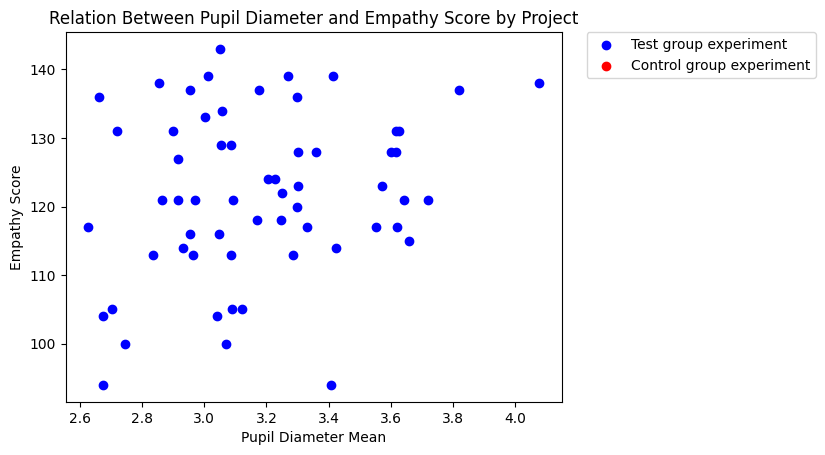

In [24]:
# Create a scatter plot with different colors for each project
unique_projects = merged_result['Project Name'].unique()
plot_colors = ['blue', 'red', 'orange'] 

fig, ax = plt.subplots()

# Iterate through each unique project and plot its data
for project, color in zip(unique_projects, plot_colors):
    project_data = merged_result[merged_result['Project Name'] == project]
    
    print(f"Processing project: {project}")
    print(f"Number of data points: {len(project_data)}")
    ax.scatter(project_data['Pupil Diameter Mean'], project_data['Total Score extended'], c=color, label=project, zorder=3)

ax.set_xlabel('Pupil Diameter Mean')
ax.set_ylabel('Empathy Score')
ax.set_title('Relation Between Pupil Diameter and Empathy Score by Project')

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.show()


In [25]:
# Create a DataFrame to store the table data
table_data = []

# Create a list of unique projects
unique_projects = merged_result['Project Name'].unique()

# Iterate through each unique project and gather data for the table
for project in unique_projects:
    project_data = merged_result[merged_result['Project Name'] == project]
    
    num_data_points = len(project_data)
    mean_pupil_diameter = project_data['Pupil Diameter Mean'].mean()
    mean_empathy_score = project_data['Total Score extended'].mean()
    
    table_data.append([project, num_data_points, mean_pupil_diameter, mean_empathy_score])

# Create a DataFrame from the collected table data
table_df = pd.DataFrame(table_data, columns=['Project Name', 'Number of Data Points', 'Mean Pupil Diameter', 'Mean Empathy Score'])

# Convert the DataFrame to a tabulated format
table_str = tabulate(table_df, headers='keys', tablefmt='grid')

# Display the table
print(table_str)

+----+--------------------------+-------------------------+-----------------------+----------------------+
|    | Project Name             |   Number of Data Points |   Mean Pupil Diameter |   Mean Empathy Score |
+====+==========================+=========================+=======================+======================+
|  0 | Test group experiment    |                     360 |               3.06326 |               121.85 |
+----+--------------------------+-------------------------+-----------------------+----------------------+
|  1 | Control group experiment |                     142 |               3.45471 |               nan    |
+----+--------------------------+-------------------------+-----------------------+----------------------+


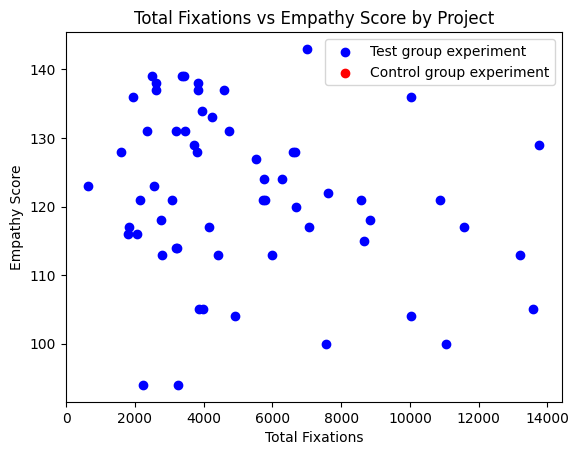

In [26]:
# Create a scatter plot with different colors for each project
unique_projects = merged_result['Project Name'].unique()
colors = ['blue', 'red'] 

fig, ax = plt.subplots()

for project, color in zip(unique_projects, colors):
    project_data = merged_result[merged_result['Project Name'] == project]
    ax.scatter(project_data['Total Fixations'], project_data['Total Score extended'], c=color, label=project)

# Add labels and title
ax.set_xlabel('Total Fixations')
ax.set_ylabel('Empathy Score')
ax.set_title('Total Fixations vs Empathy Score by Project')

ax.legend()

plt.show()

## # standard deviations and dimensions of each participant's trails

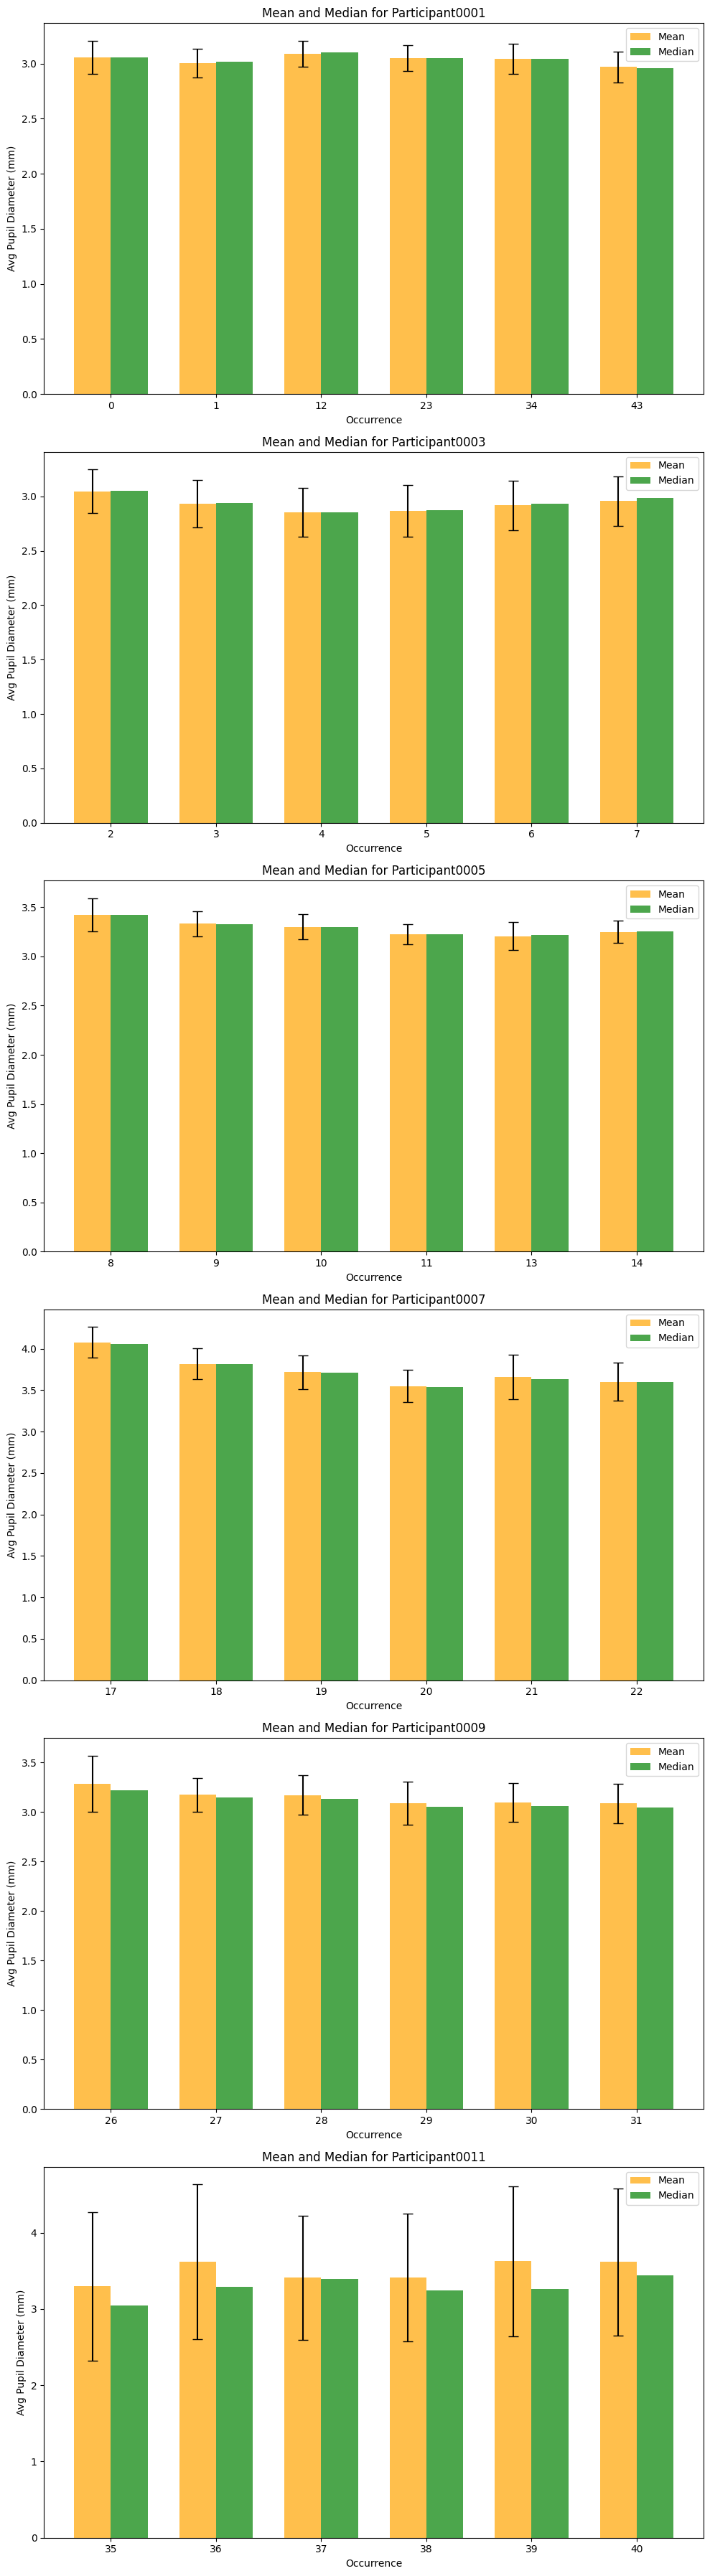

       Participant  Occurrence 1 Mean  Occurrence 2 Mean  Occurrence 3 Mean  \
0  Participant0001           3.056368           3.003070           3.088603   
1  Participant0003           3.046213           2.930768           2.854551   
2  Participant0005           3.424232           3.331768           3.301643   
3  Participant0007           4.076853           3.819665           3.719455   
4  Participant0009           3.284482           3.174954           3.168828   
5  Participant0011           3.298744           3.618580           3.408425   

   Occurrence 4 Mean  Occurrence 5 Mean  Occurrence 6 Mean  \
0           3.049942           3.042667           2.969416   
1           2.865262           2.915673           2.955402   
2           3.226111           3.204423           3.251135   
3           3.551302           3.658972           3.600918   
4           3.086688           3.093350           3.085145   
5           3.414679           3.624641           3.616116   

   Occurren

In [27]:
# Get unique participant names
unique_participants = merged_result['Participant Name'].unique()

selected_participants = unique_participants[:6]

# Create subplots
fig, axs = plt.subplots(nrows=len(selected_participants), figsize=(10, 6*len(selected_participants)))
plt.subplots_adjust(hspace=0.5) 

#Initialize a table for storing data
table_data = []

for i, participant in enumerate(selected_participants):
    participant_data = merged_result[merged_result['Participant Name'] == participant]
    participant_data = participant_data.reset_index().rename(columns={'index': 'occurrence'}).head(6)

    grouped_data = participant_data.groupby('occurrence').agg({'Pupil Diameter Mean': 'mean', 'Pupil Diameter Median': 'mean', 'Pupil Diameter Std': 'mean'}).reset_index()

    ax = axs[i]

    # Create a bar plot showing mean and median with error bars for standard deviation
    x = np.arange(len(grouped_data))
    width = 0.35

    ax.bar(x - width/2, grouped_data['Pupil Diameter Mean'], width, label='Mean', yerr=grouped_data['Pupil Diameter Std'], capsize=5, color='orange', alpha=0.7)
    ax.bar(x + width/2, grouped_data['Pupil Diameter Median'], width, label='Median', color='green', alpha=0.7)


    ax.set_xlabel('Occurrence')
    ax.set_ylabel('Avg Pupil Diameter (mm)')
    ax.set_title(f'Mean and Median for {participant}')

    # Set x-axis ticks and labels
    ax.set_xticks(x)
    ax.set_xticklabels(grouped_data['occurrence'])

    # Add legend
    ax.legend()
    
    # Store data for the table
    table_data.append([participant] + grouped_data['Pupil Diameter Mean'].tolist() + grouped_data['Pupil Diameter Median'].tolist())


# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

# Create a table using tabulate
table_headers = ['Participant', 'Occurrence 1 Mean', 'Occurrence 2 Mean', 'Occurrence 3 Mean', 'Occurrence 4 Mean', 'Occurrence 5 Mean', 'Occurrence 6 Mean',
                 'Occurrence 1 Median', 'Occurrence 2 Median', 'Occurrence 3 Median', 'Occurrence 4 Median', 'Occurrence 5 Median', 'Occurrence 6 Median']

table_df = pd.DataFrame(table_data, columns=table_headers)


print(table_df)

## # Assess control and test groups separately

In [28]:
# Create a dictionary to store the DataFrames
project_data_frames = {}

# Iterate over each unique project name
for project_name in unique_projects:
    
    filtered_data = merged_result[merged_result['Project Name'] == project_name]

    
    project_data_frames[project_name] = filtered_data

In [73]:
target_project_name = 'Control group experiment'
target_project_control_dataframe = project_data_frames[target_project_name]


target_project_dataframe.head()

,Participant Name,Project Name,Recording Name,Total Fixations,Avg. Fixation Duration,Pupil Diameter Mean,Pupil Diameter Median,Pupil Diameter Std,Gaze Point X Mean,Gaze Point X Median,Gaze Point X Std,Gaze Point Y Mean,Gaze Point Y Median,Gaze Point Y Std,Fixation Point X Mean,Fixation Point X Median,Fixation Point X Std,Fixation Point Y Mean,Fixation Point Y Median,Fixation Point Y Std,Total Score extended
360,Participant0010,Control group experiment,Recording1,5392,379.059162,3.232730,3.1925,0.237403,971.247027,975.0,263.182466,441.096289,388.0,183.610188,973.921957,976.0,269.719731,440.103826,384.0,183.261750,NaN
361,Participant0010,Control group experiment,Recording2,5283,444.489495,3.212415,3.2000,0.219015,978.398370,1000.0,296.765427,484.556360,430.0,232.864399,975.935718,988.0,285.409471,505.873218,497.0,234.490119,NaN
362,Participant0010,Control group experiment,Recording3,4444,324.807381,3.331669,3.3500,0.178924,998.712701,1005.0,415.700782,554.162540,539.0,297.713544,1047.289042,1032.0,414.983677,513.659821,491.0,299.968004,NaN
363,Participant0010,Control group experiment,Recording4,3389,383.489230,3.335825,3.2850,0.163420,1003.353020,1024.0,488.898311,587.964254,564.5,335.685098,1005.081311,1023.0,422.449168,602.277541,638.0,292.386144,NaN
364,Participant0014,Control group experiment,Recording2,1182,300.842640,2.836248,2.8300,0.273001,1016.897923,983.0,143.591409,481.736213,477.0,187.390031,1003.519732,967.0,120.573719,503.638334,465.0,181.645100,NaN


In [76]:
# Creating a new DataFrame with relevant columns
selected_columns = ['Participant Name', 'Project Name', 'Pupil Diameter Std', 'Pupil Diameter Mean', 'Pupil Diameter Median', 'Recording Name', 'Total Score extended']
pupil_control_data = target_project_control_dataframe[selected_columns].copy()

# Display the initial rows of the newly created DataFrame
pupil_control_data.head()

,Participant Name,Project Name,Pupil Diameter Std,Pupil Diameter Mean,Pupil Diameter Median,Recording Name,Total Score extended
360,Participant0010,Control group experiment,0.237403,3.232730,3.1925,Recording1,NaN
361,Participant0010,Control group experiment,0.219015,3.212415,3.2000,Recording2,NaN
362,Participant0010,Control group experiment,0.178924,3.331669,3.3500,Recording3,NaN
363,Participant0010,Control group experiment,0.163420,3.335825,3.2850,Recording4,NaN
364,Participant0014,Control group experiment,0.273001,2.836248,2.8300,Recording2,NaN


## # Split control group data using StratifiedKFold

In [77]:
# Load the dataset and separate features and target
input_data = target_project_control_dataframe
features = input_data.drop(['Project Name', 'Total Score extended'], axis=1)
target = input_data['Total Score extended']
group_labels = input_data['Project Name']  # Used for stratification

# Reset indices of features and target DataFrames
features.reset_index(drop=True, inplace=True)
target.reset_index(drop=True, inplace=True)
group_labels.reset_index(drop=True, inplace=True)


# Define the number of splits for cross-validation
num_splits = 5

# Initialize the StratifiedKFold cross-validator
stratified_kfold = StratifiedKFold(n_splits=num_splits)

# Iterate over the cross-validation splits
for fold, (train_indices, test_indices) in enumerate(stratified_kfold.split(features, group_labels)):
    # Get the training and testing data for this fold
    X_train, X_test = features.iloc[train_indices], features.iloc[test_indices]
    y_train, y_test = target.iloc[train_indices], target.iloc[test_indices]

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(114, 19)
(28, 19)
(114,)
(28,)


In [78]:
target_project_name = 'Test group experiment'
target_project_test_dataframe = project_data_frames[target_project_name]


target_project_test_dataframe.head()

,Participant Name,Project Name,Recording Name,Total Fixations,Avg. Fixation Duration,Pupil Diameter Mean,Pupil Diameter Median,Pupil Diameter Std,Gaze Point X Mean,Gaze Point X Median,Gaze Point X Std,Gaze Point Y Mean,Gaze Point Y Median,Gaze Point Y Std,Fixation Point X Mean,Fixation Point X Median,Fixation Point X Std,Fixation Point Y Mean,Fixation Point Y Median,Fixation Point Y Std,Total Score extended
0,Participant0001,Test group experiment,Recording1,3959,271.230866,3.056368,3.055,0.146976,1070.355771,1024.0,273.425806,253.597742,263.0,293.880068,1068.048486,1025.0,267.415656,240.014733,283.0,273.403386,134.0
1,Participant0001,Test group experiment,Recording2,4235,224.831641,3.003070,3.015,0.129013,965.955342,965.0,306.457171,306.260339,324.0,273.827454,963.202383,963.0,313.929984,293.415570,316.0,286.250816,133.0
2,Participant0003,Test group experiment,Recording11,2070,157.457005,3.046213,3.050,0.199396,1017.325455,1000.0,304.629167,555.689808,608.0,301.311213,1025.024750,995.0,321.610589,511.385828,575.0,302.463961,116.0
3,Participant0003,Test group experiment,Recording12,3194,135.623043,2.930768,2.940,0.216362,984.012235,991.0,277.920121,588.452621,594.0,287.156051,966.134572,998.0,293.505633,583.479270,570.0,320.345364,114.0
4,Participant0003,Test group experiment,Recording13,2605,135.343954,2.854551,2.855,0.225505,1005.079682,994.0,303.708457,534.013693,541.0,291.773511,1014.128752,989.0,329.832332,500.207664,514.0,312.883568,138.0


## # Split test group data using StratifiedKFold

In [79]:
# Load the dataset and separate features and target
input_data = target_project_test_dataframe
features = input_data.drop(['Participant Name', 'Total Score extended'], axis=1)
target = input_data['Total Score extended']
group_labels = input_data['Participant Name']  # Used for stratification

# Check for missing values in the target array
print("Number of missing values in target:", target.isnull().sum())

# Define the number of splits for cross-validation
num_splits = 5

# Initialize the StratifiedKFold cross-validator
stratified_kfold = StratifiedKFold(n_splits=num_splits)

# Iterate over the cross-validation splits
for fold, (train_indices, test_indices) in enumerate(stratified_kfold.split(features, group_labels)):
    # Get the training and testing data for this fold
    X_train, X_test = features.iloc[train_indices], features.iloc[test_indices]
    y_train, y_test = target.iloc[train_indices], target.iloc[test_indices]

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

Number of missing values in target: 300
(288, 19)
(72, 19)
(288,)
(72,)


# # Assess another dataset for pupil

Empathy analysis may be dependent on pupil features. This approach involves focusing on the pupil to predict empathy and ignoring other features that may be less relevant.

In [80]:
# Creating a new DataFrame with relevant columns
selected_columns = ['Participant Name', 'Project Name', 'Pupil Diameter Std', 'Pupil Diameter Mean', 'Pupil Diameter Median', 'Recording Name', 'Total Score extended']
pupil_test_data = target_project_test_dataframe[selected_columns].copy()

# Display the initial rows of the newly created DataFrame
pupil_test_data.head()

,Participant Name,Project Name,Pupil Diameter Std,Pupil Diameter Mean,Pupil Diameter Median,Recording Name,Total Score extended
0,Participant0001,Test group experiment,0.146976,3.056368,3.055,Recording1,134.0
1,Participant0001,Test group experiment,0.129013,3.003070,3.015,Recording2,133.0
2,Participant0003,Test group experiment,0.199396,3.046213,3.050,Recording11,116.0
3,Participant0003,Test group experiment,0.216362,2.930768,2.940,Recording12,114.0
4,Participant0003,Test group experiment,0.225505,2.854551,2.855,Recording13,138.0


## # correlation matrix for control group experiment and test group experiment

In [89]:
def plot_correlation_heatmap(data_frame, target_feature, num_features=15):
    
    corr_matrix = data_frame.corr()

    # Select the top_n columns with the highest correlation
    cols = corr_matrix.nlargest(num_features, target_feature)[target_feature].index

    cm = data_frame[cols].corr()

    plt.figure(figsize=(10, 10))
    ax = sns.heatmap(cm, annot=True, cmap='viridis')
    ax.set_title('Top Correlation Heatmap for ' + target_feature)

    plt.show()
    
    return

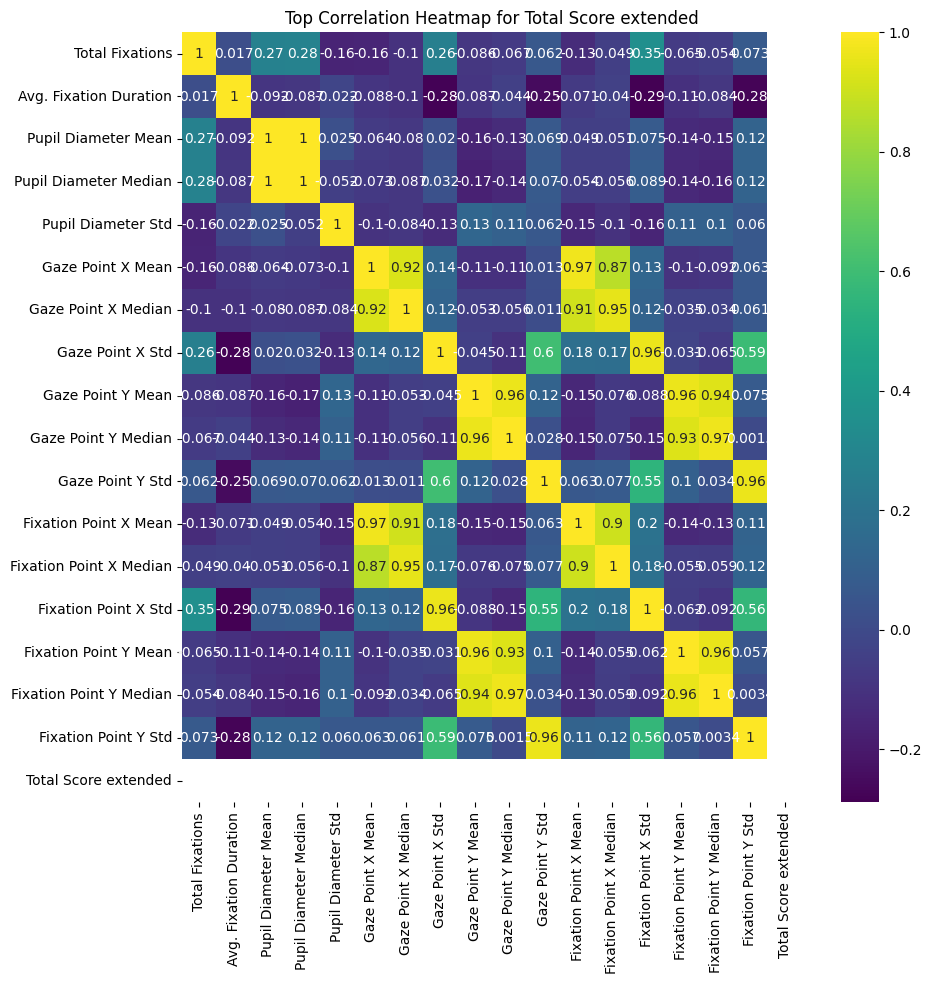

In [91]:
plot_correlation_heatmap(target_project_dataframe, 'Total Score extended', num_features=20)

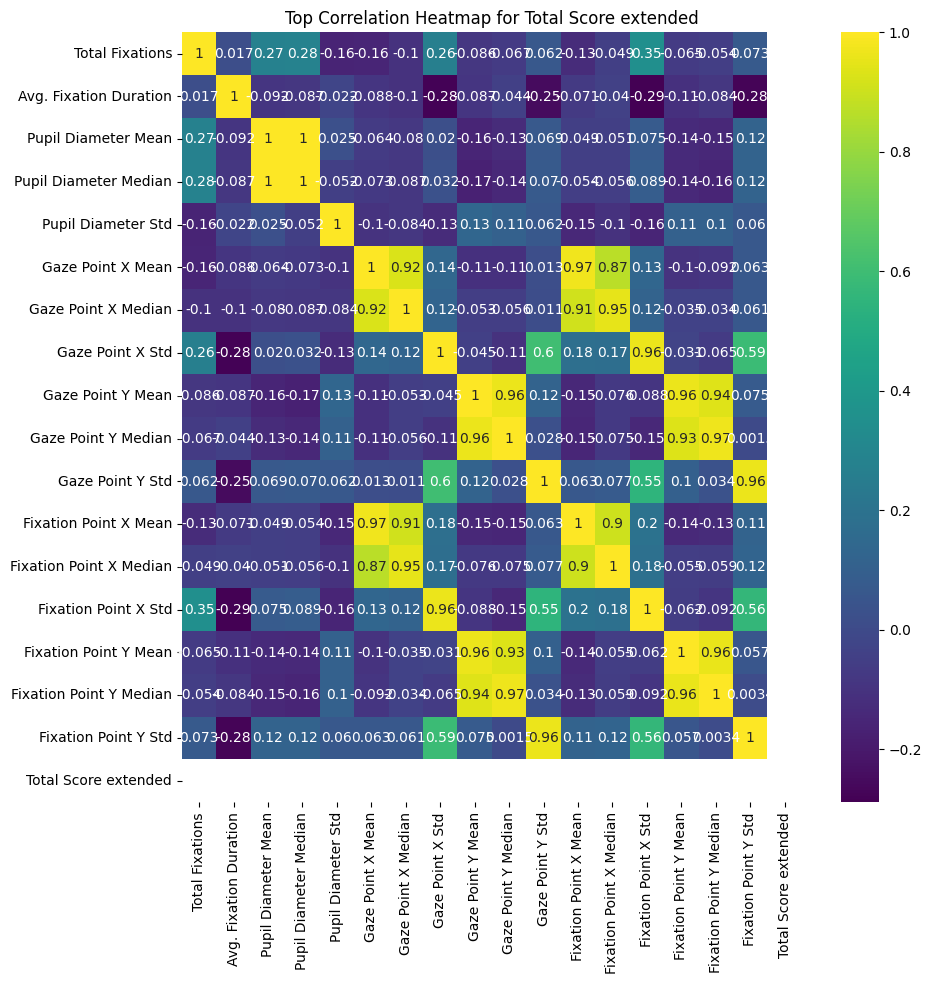

In [92]:
plot_correlation_heatmap(target_project_dataframe, 'Total Score extended', num_features=20)

## # Classification Model

Train and evaluate the control group to predict empathy score.

In [36]:
def train_and_evaluate_model(data_frame, group_label, model_type='regressor'):
    # Remove rows with missing target values
    data_frame = data_frame.dropna(subset=['Total Score extended'])
    
    # Extract features (X) and target (y) variables
    X_features = data_frame.drop(columns=['Total Score extended', 'Project Name', 'Recording Name'])
    y_target = data_frame['Total Score extended']
    
    # Initialize an empty DataFrame to store results
    evaluation_results = pd.DataFrame(columns=['Participant Name', 'Original Empathy Score', 'Predicted Empathy Score'])
    
    # Encode participant names using LabelEncoder
    participant_encoder = LabelEncoder()
    X_features['Participant Name'] = participant_encoder.fit_transform(X_features['Participant Name'])
    participant_groups = data_frame['Participant Name']
    
    # Set the number of splits equal to the number of unique participant groups
    n_splits = 8
    group_kfold = GroupKFold(n_splits=n_splits)
    
    
    # Lists to store evaluation metrics
    mse_scores = []
    r2_scores = []
    rmse_scores = []
    medae_scores = []
    y_test_all = []
    y_pred_all = []
    
     # Determine the model type and initialize the model
    if model_type == 'regressor':
        model = RandomForestRegressor()
    elif model_type == 'classifier':
        model = DecisionTreeClassifier()
    elif model_type == 'logistic':
        model = LogisticRegression()
    else:
        raise ValueError("Invalid model type. Choose 'regressor' or 'classifier'.")
    
    
    # Iterate through folds using GroupKFold
    for fold, (train_index, test_index) in enumerate(group_kfold.split(X_features, y_target, groups=participant_groups)):
        X_train, X_test = X_features.iloc[train_index], X_features.iloc[test_index]
        y_train, y_test = y_target.iloc[train_index], y_target.iloc[test_index]
        
        # Initialize and train the model (RandomForestRegressor)
#         model = RandomForestRegressor()
        model.fit(X_train, y_train)
        
        # Make predictions on the test set
        y_pred = model.predict(X_test)
        
        
        print(f"Fold {fold + 1}:")
        
        for idx, (participant, original_score) in enumerate(zip(data_frame.iloc[test_index]['Participant Name'], y_test)):
            predicted_score = y_pred[idx]
            print(f"  Participant Name: {participant}, Original Empathy Score: {original_score}, Predicted Empathy Score: {predicted_score:.2f}")
            
            # Store the results for this fold
            evaluation_results = evaluation_results.append({'Participant Name': participant,
                                                            'Original Empathy Score': original_score,
                                                            'Predicted Empathy Score': predicted_score,},
                                                           
                                                           ignore_index=True)
        
        # Calculate evaluation metrics for this fold
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)
        medae = median_absolute_error(y_test, y_pred)
        
        # Store metrics in lists for averaging later
        mse_scores.append(mse)
        rmse_scores.append(rmse)
        r2_scores.append(r2)
        medae_scores.append(medae)
        y_test_all.extend(y_test)
        y_pred_all.extend(y_pred)
    
    # Calculate average evaluation metrics
    avg_rmse = np.mean(rmse_scores)
    avg_r2 = np.mean(r2_scores)
    avg_medae = np.mean(medae_scores)
        
    
    print(f"Average Root Mean Squared Error: {avg_rmse}")
    print(f"Average R-squared: {avg_r2}")
    print(f"Average Median Absolute Error: {avg_medae}")
    
    
    return evaluation_results

In [38]:
print("*** Train and Evaluate Model using RandomForestRegressor on Control Group***")
target_project_control_evaluation = train_and_evaluate_model(target_project_dataframe, "Control Group", model_type='regressor')
target_project_control_evaluation.head()

*** Train and Evaluate Model using RandomForestRegressor on Control Group***
Fold 1:
  Participant Name: Participant0013, Original Empathy Score: 121.0, Predicted Empathy Score: 124.51
  Participant Name: Participant0013, Original Empathy Score: 113.0, Predicted Empathy Score: 132.14
  Participant Name: Participant0013, Original Empathy Score: 100.0, Predicted Empathy Score: 130.09
  Participant Name: Participant0013, Original Empathy Score: 105.0, Predicted Empathy Score: 128.05
  Participant Name: Participant0013, Original Empathy Score: 104.0, Predicted Empathy Score: 129.14
  Participant Name: Participant0013, Original Empathy Score: 136.0, Predicted Empathy Score: 127.70
  Participant Name: Participant0013, Original Empathy Score: 117.0, Predicted Empathy Score: 129.02
  Participant Name: Participant0013, Original Empathy Score: 94.0, Predicted Empathy Score: 129.49
Fold 2:
  Participant Name: Participant0011, Original Empathy Score: 136.0, Predicted Empathy Score: 119.22
  Partic

,Participant Name,Original Empathy Score,Predicted Empathy Score
0,Participant0013,121.0,124.51
1,Participant0013,113.0,132.14
2,Participant0013,100.0,130.09
3,Participant0013,105.0,128.05
4,Participant0013,104.0,129.14


In [39]:
print("*** Train and Evaluate Model using DecisionTreeClassifier on Control Group***")
results_control_classifier = train_and_evaluate_model(target_project_dataframe, "Control Group", model_type='classifier')
target_project_control_evaluation.head()

*** Train and Evaluate Model using DecisionTreeClassifier on Control Group***
Fold 1:
  Participant Name: Participant0013, Original Empathy Score: 121.0, Predicted Empathy Score: 131.00
  Participant Name: Participant0013, Original Empathy Score: 113.0, Predicted Empathy Score: 131.00
  Participant Name: Participant0013, Original Empathy Score: 100.0, Predicted Empathy Score: 131.00
  Participant Name: Participant0013, Original Empathy Score: 105.0, Predicted Empathy Score: 131.00
  Participant Name: Participant0013, Original Empathy Score: 104.0, Predicted Empathy Score: 131.00
  Participant Name: Participant0013, Original Empathy Score: 136.0, Predicted Empathy Score: 131.00
  Participant Name: Participant0013, Original Empathy Score: 117.0, Predicted Empathy Score: 131.00
  Participant Name: Participant0013, Original Empathy Score: 94.0, Predicted Empathy Score: 131.00
Fold 2:
  Participant Name: Participant0011, Original Empathy Score: 136.0, Predicted Empathy Score: 116.00
  Parti

,Participant Name,Original Empathy Score,Predicted Empathy Score
0,Participant0013,121.0,124.51
1,Participant0013,113.0,132.14
2,Participant0013,100.0,130.09
3,Participant0013,105.0,128.05
4,Participant0013,104.0,129.14


In [40]:
print("*** Train and Evaluate Model using LogisticRegression on Control Group***")
target_project_control_evaluation = train_and_evaluate_model(target_project_dataframe, "Control Group", model_type='logistic')
target_project_control_evaluation.head()

*** Train and Evaluate Model using LogisticRegression on Control Group***
Fold 1:
  Participant Name: Participant0013, Original Empathy Score: 121.0, Predicted Empathy Score: 137.00
  Participant Name: Participant0013, Original Empathy Score: 113.0, Predicted Empathy Score: 117.00
  Participant Name: Participant0013, Original Empathy Score: 100.0, Predicted Empathy Score: 113.00
  Participant Name: Participant0013, Original Empathy Score: 105.0, Predicted Empathy Score: 143.00
  Participant Name: Participant0013, Original Empathy Score: 104.0, Predicted Empathy Score: 113.00
  Participant Name: Participant0013, Original Empathy Score: 136.0, Predicted Empathy Score: 113.00
  Participant Name: Participant0013, Original Empathy Score: 117.0, Predicted Empathy Score: 113.00
  Participant Name: Participant0013, Original Empathy Score: 94.0, Predicted Empathy Score: 117.00
Fold 2:
  Participant Name: Participant0011, Original Empathy Score: 136.0, Predicted Empathy Score: 116.00
  Participa

,Participant Name,Original Empathy Score,Predicted Empathy Score
0,Participant0013,121.0,137.0
1,Participant0013,113.0,117.0
2,Participant0013,100.0,113.0
3,Participant0013,105.0,143.0
4,Participant0013,104.0,113.0


In [43]:
target_project_control_evaluation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 3 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Participant Name         60 non-null     object 
 1   Original Empathy Score   60 non-null     float64
 2   Predicted Empathy Score  60 non-null     float64
dtypes: float64(2), object(1)
memory usage: 1.5+ KB


In [44]:
def actual_vs_predicted_plot(predictions_dataframe,title):
    true_scores = predictions_dataframe['Original Empathy Score'].tolist()
    predicted_scores = predictions_dataframe['Predicted Empathy Score'].tolist()

    plt.scatter(true_scores, predicted_scores, color='green', label='Predicted')
    plt.xlabel('Original Empathy Score')
    plt.ylabel('Predicted Empathy Scores')
    plt.title(f'Actual vs. Predicted Empathy Scores ({title})')

    # Add a line representing perfect prediction
    min_value = min(min(true_scores), min(predicted_scores))
    max_value = max(max(true_scores), max(predicted_scores))
    plt.plot([min_value, max_value], [min_value, max_value], color='red', label='Perfect Prediction')

    plt.legend()
    plt.show()
    
    return

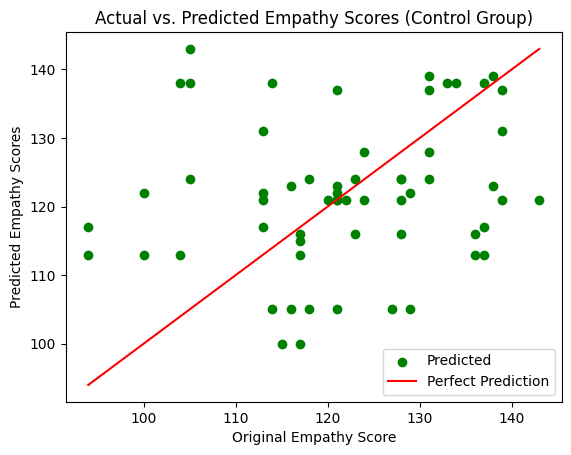

In [45]:
actual_vs_predicted_plot(target_project_control_evaluation, 'Control Group')

Train and evaluate the test group to predict empathy score.

In [46]:
target_project_test_evaluation = train_and_evaluate_model(target_project_dataframe, "Test Group", model_type='regressor')
target_project_test_evaluation.head()

Fold 1:
  Participant Name: Participant0013, Original Empathy Score: 121.0, Predicted Empathy Score: 124.85
  Participant Name: Participant0013, Original Empathy Score: 113.0, Predicted Empathy Score: 131.80
  Participant Name: Participant0013, Original Empathy Score: 100.0, Predicted Empathy Score: 129.11
  Participant Name: Participant0013, Original Empathy Score: 105.0, Predicted Empathy Score: 127.68
  Participant Name: Participant0013, Original Empathy Score: 104.0, Predicted Empathy Score: 129.47
  Participant Name: Participant0013, Original Empathy Score: 136.0, Predicted Empathy Score: 127.91
  Participant Name: Participant0013, Original Empathy Score: 117.0, Predicted Empathy Score: 129.18
  Participant Name: Participant0013, Original Empathy Score: 94.0, Predicted Empathy Score: 127.94
Fold 2:
  Participant Name: Participant0011, Original Empathy Score: 136.0, Predicted Empathy Score: 121.30
  Participant Name: Participant0011, Original Empathy Score: 117.0, Predicted Empathy

,Participant Name,Original Empathy Score,Predicted Empathy Score
0,Participant0013,121.0,124.85
1,Participant0013,113.0,131.80
2,Participant0013,100.0,129.11
3,Participant0013,105.0,127.68
4,Participant0013,104.0,129.47


In [47]:
target_project_test_evaluation = train_and_evaluate_model(target_project_dataframe, "Test Group", model_type='classifier')
target_project_test_evaluation.head()

Fold 1:
  Participant Name: Participant0013, Original Empathy Score: 121.0, Predicted Empathy Score: 117.00
  Participant Name: Participant0013, Original Empathy Score: 113.0, Predicted Empathy Score: 123.00
  Participant Name: Participant0013, Original Empathy Score: 100.0, Predicted Empathy Score: 123.00
  Participant Name: Participant0013, Original Empathy Score: 105.0, Predicted Empathy Score: 123.00
  Participant Name: Participant0013, Original Empathy Score: 104.0, Predicted Empathy Score: 123.00
  Participant Name: Participant0013, Original Empathy Score: 136.0, Predicted Empathy Score: 123.00
  Participant Name: Participant0013, Original Empathy Score: 117.0, Predicted Empathy Score: 117.00
  Participant Name: Participant0013, Original Empathy Score: 94.0, Predicted Empathy Score: 123.00
Fold 2:
  Participant Name: Participant0011, Original Empathy Score: 136.0, Predicted Empathy Score: 116.00
  Participant Name: Participant0011, Original Empathy Score: 117.0, Predicted Empathy

,Participant Name,Original Empathy Score,Predicted Empathy Score
0,Participant0013,121.0,117.0
1,Participant0013,113.0,123.0
2,Participant0013,100.0,123.0
3,Participant0013,105.0,123.0
4,Participant0013,104.0,123.0


In [48]:
target_project_test_evaluation = train_and_evaluate_model(target_project_dataframe, "Test Group", model_type='logistic')
target_project_test_evaluation.head()

Fold 1:
  Participant Name: Participant0013, Original Empathy Score: 121.0, Predicted Empathy Score: 137.00
  Participant Name: Participant0013, Original Empathy Score: 113.0, Predicted Empathy Score: 117.00
  Participant Name: Participant0013, Original Empathy Score: 100.0, Predicted Empathy Score: 113.00
  Participant Name: Participant0013, Original Empathy Score: 105.0, Predicted Empathy Score: 143.00
  Participant Name: Participant0013, Original Empathy Score: 104.0, Predicted Empathy Score: 113.00
  Participant Name: Participant0013, Original Empathy Score: 136.0, Predicted Empathy Score: 113.00
  Participant Name: Participant0013, Original Empathy Score: 117.0, Predicted Empathy Score: 113.00
  Participant Name: Participant0013, Original Empathy Score: 94.0, Predicted Empathy Score: 117.00
Fold 2:
  Participant Name: Participant0011, Original Empathy Score: 136.0, Predicted Empathy Score: 116.00
  Participant Name: Participant0011, Original Empathy Score: 117.0, Predicted Empathy

,Participant Name,Original Empathy Score,Predicted Empathy Score
0,Participant0013,121.0,137.0
1,Participant0013,113.0,117.0
2,Participant0013,100.0,113.0
3,Participant0013,105.0,143.0
4,Participant0013,104.0,113.0


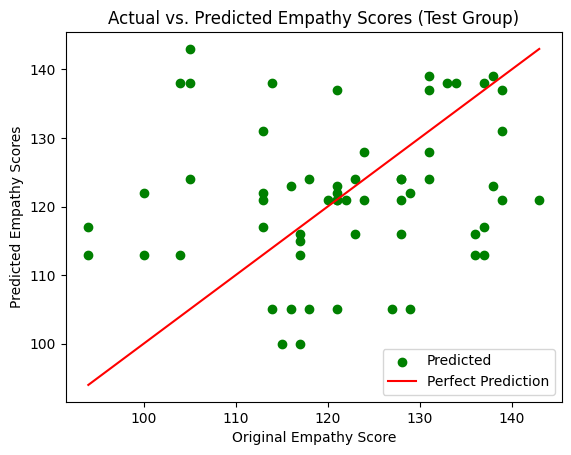

In [49]:
actual_vs_predicted_plot(target_project_test_evaluation, 'Test Group')

## # Empathy Prediction Outcomes

Calculate the average empathy score for each participant's determine overall predicted empathy.

In [60]:
def visualize_empathy_scores_summary(data_df):
    # Calculate the mean of original and predicted empathy scores for each participant
    summary_df = data_df.groupby('Participant Name').agg({
        'Original Empathy Score': 'first',
        'Predicted Empathy Score': 'mean'
    })

    # Display all rows and columns
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)

    print("Participant-wise Summary DataFrame:")
    print(summary_df.to_markdown(tablefmt="grid"))

    # Reshape the summary dataframe for visualization
    melted_df = summary_df.reset_index().melt(
        id_vars=['Participant Name'],
        value_vars=['Original Empathy Score', 'Predicted Empathy Score'],
        var_name='Score_Type',
        value_name='Score'
    )

    # Display scores for a subset of participants
    first_n_participants = melted_df['Participant Name'].unique()[:7]
    filtered_df = melted_df[melted_df['Participant Name'].isin(first_n_participants)]

    
    # Set a custom color palette
    colors = ['#b41f4e', '#601fb4']
    
    # Create a bar plot to visualize original and predicted scores
    plt.figure(figsize=(10, 5))
    sns.pointplot(data=filtered_df, x='Participant Name', y='Score', hue='Score_Type', palette=colors, markers=['o', 's'])

    plt.title('Comparison of Actual and Predicted Empathy Scores for Select Participants')
    plt.xlabel('Participant Name')
    plt.ylabel('Empathy Score')

    plt.show()

    return

Participant-wise Summary DataFrame:
+--------------------+--------------------------+---------------------------+
| Participant Name   |   Original Empathy Score |   Predicted Empathy Score |
+====================+==========================+===========================+
| Participant0001    |                      134 |                   131.625 |
+--------------------+--------------------------+---------------------------+
| Participant0003    |                      116 |                   109.5   |
+--------------------+--------------------------+---------------------------+
| Participant0005    |                      114 |                   123.25  |
+--------------------+--------------------------+---------------------------+
| Participant0007    |                      138 |                   118     |
+--------------------+--------------------------+---------------------------+
| Participant0009    |                      113 |                   123     |
+--------------------+------

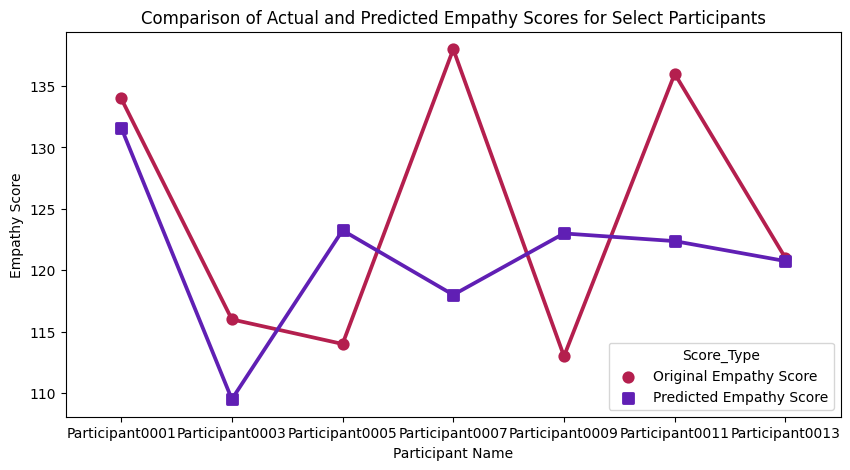

In [61]:
visualize_empathy_scores_summary(target_project_test_evaluation)

Participant-wise Summary DataFrame:
+--------------------+--------------------------+---------------------------+
| Participant Name   |   Original Empathy Score |   Predicted Empathy Score |
+====================+==========================+===========================+
| Participant0001    |                      134 |                   131.625 |
+--------------------+--------------------------+---------------------------+
| Participant0003    |                      116 |                   109.5   |
+--------------------+--------------------------+---------------------------+
| Participant0005    |                      114 |                   123.25  |
+--------------------+--------------------------+---------------------------+
| Participant0007    |                      138 |                   118     |
+--------------------+--------------------------+---------------------------+
| Participant0009    |                      113 |                   123     |
+--------------------+------

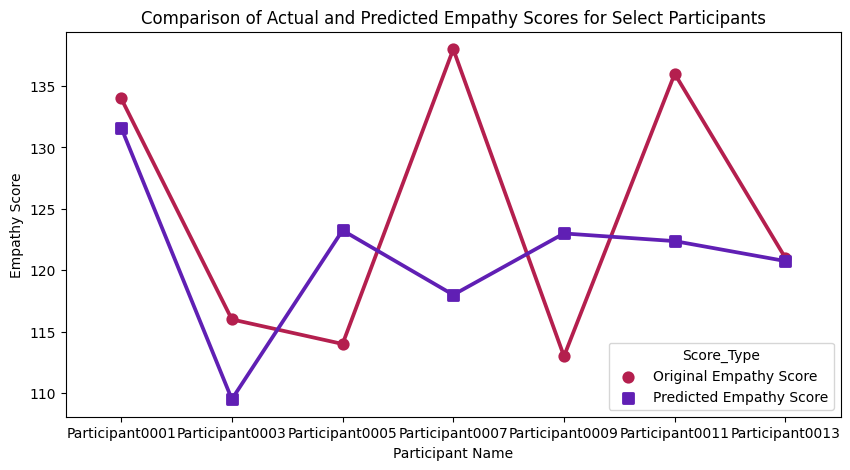

In [62]:
visualize_empathy_scores_summary(target_project_control_evaluation)